<a href="https://colab.research.google.com/github/SaxMan96/Harmony-Analyzer/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install pyRealParser
!pip install pychord

  Created wheel for pyRealParser: filename=pyRealParser-0.1.0-cp36-none-any.whl size=6830 sha256=93dd41bdf744d035ff1573abaee38584d11b8fc1a219007804db59888accb4dc
  Stored in directory: /root/.cache/pip/wheels/5e/9c/44/4d74ebd89107df4c625c81437cad9aa8ee55afb26e251d90fa
Successfully built pyRealParser
  Created wheel for pychord: filename=pychord-0.4.1-py2.py3-none-any.whl size=9935 sha256=90ad4d2800589a3850f633fd0c33ad4a7c738374016997c46c2f9ff59fa52c74
  Stored in directory: /root/.cache/pip/wheels/40/ea/ad/0233db8ea21a1e66c4ea0ead8f3437199f8e5902faa02834f8
Successfully built pychord


LSTM requirements:

- The LSTM input layer must be 3D.
- LSTMs don’t like sequences of more than 200-400 time steps, so the data will need to be split into samples.
- If you have a long sequence of thousands of observations, you must split it into samples and then reshape it for your LSTM model.
- The LSTM needs data with the format of [samples, time steps and features].
- The LSTM input layer is defined by the input_shape argument on the first hidden layer.
- The input_shape argument takes a tuple of two values that define the number of time steps and features.
- The number of samples is assumed to be 1 or more.
- The reshape() function on NumPy arrays can be used to reshape your 1D or 2D data to be 3D.
- The reshape() function takes a tuple as an argument that defines the new shape.


# Imports

In [26]:
import utilities as my_utils
from multihotembedding import MultihotEmbedding
# from utilities import *

import pandas as pd
import numpy as np
import ast
import time
from collections import Counter, OrderedDict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from music21.harmony import chordSymbolFigureFromChord as figureChord
from music21.chord import Chord

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing import sequence
from tensorflow.python.keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout
import tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix


from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

import gensim
import tensorflow as tf
from tensorflow import keras
import sklearn

import warnings
warnings.filterwarnings(action="once")

print("Using TensorFlow %s" % tf.__version__)
print("Using Gensim %s" % gensim.__version__)
print("Using Keras %s" % keras.__version__)
print("Using Sklearn %s" % sklearn.__version__)

Using TensorFlow 2.2.0
Using Gensim 3.8.3
Using Keras 2.3.0-tf
Using Sklearn 0.23.1


# Data Transformations

In [27]:
class Metrics(Callback):
    def __init__(self, tr_data, val_data):
        self.validation_data = val_data    
        self.train_data = tr_data    
    
    def cosine_distance_sum(self, A, B):
        return sum([1.0 - np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(A, B)])

    def mean_cos_dist_sum(self, X_vali, y_vali):
        y_pred = model.predict(X_vali)
        return self.cosine_distance_sum(y_pred, y_vali)/y_vali.shape[0]
        
    def on_train_begin(self, logs={}):
        self.mean_cos_dist = []      
        self.val_mean_cos_dist = []       
        
    def on_epoch_end(self, epoch, logs={}):
        score = self.mean_cos_dist_sum(self.train_data[0][:1000], self.train_data[1][:1000])
        score_val = self.mean_cos_dist_sum(self.validation_data[0][:1000], self.validation_data[1][:1000])
        self.mean_cos_dist.append(score)
        self.val_mean_cos_dist.append(score_val)        
        print('\nepoch {},\tloss {:3.4f},\tval_loss {:3.4f}\tmean_cos_dist {:3.4f}\tval_mean_cos_dist {:3.4f}.'.format(
            epoch, logs['loss'], logs['val_loss'], score.item(), score_val.item()))
        
    def on_train_end(self, logs={}):
        self.mean_cos_dist = {'mean_cos_dist': self.mean_cos_dist}    
        self.val_mean_cos_dist = {'val_mean_cos_dist': self.val_mean_cos_dist}      
        
    def get_train_data(self):
        return self.train_data
    
    def get_val_data(self):
        return self.validation_data
    
def get_index_dicts(sentences):
    unique_words = set(x for l in sentences for x in l)
    word2index = dict((c, i) for i, c in enumerate(unique_words))
    index2word = dict((i, c) for i, c in enumerate(unique_words))
    return word2index, index2word

def index_transform(sequences, word2index):
    sequences_indexed = []
    for seq in tqdm(sequences, total=len(sequences), desc='Indexing'):
        seq_indexed = []
        for word in seq:
            seq_indexed.append(word2index[word])
        sequences_indexed.append(seq_indexed)
    return sequences_indexed

def embedding_transform(sequences, model):
    sequences_embedded = []
    for seq in tqdm(sequences, total=len(sequences), desc=str(model).split("(")[0]):
        seq_embedded = []
        for word in seq:
            seq_embedded.append(model.wv[word])
        sequences_embedded.append(np.array(seq_embedded))
    return sequences_embedded

def prep_subsequences(songs, seq_len = 3):
    # Remove too short songs
    songs = [song for song in songs if len(song) > seq_len+1]
    x = []
    y = []
    for song in songs:
        for i in range(len(song)):
            if i < len(song) - seq_len+1:
                x.append(song[i: i + seq_len])
            else:
                x.append(np.concatenate([song[i: len(song) - 1],song[: (i + seq_len+1) % len(song)]]))
            y.append(song[(i + seq_len+1) % len(song)])
    x = np.array(x)
    y = np.array(y)
    return x, y

def get_data(sentences, encoding_type, seq_len):
    if encoding_type == "Indexed":
        word2index, _ = get_index_dicts(sentences)
        words_encoded = index_transform(sentences, word2index)
    else:
        if encoding_type == "FastText":
            embedding_model = FastText(sentences=sentences, min_count=1, size=13, window=2)
        elif encoding_type == "Word2VecCBOW":
            embedding_model = Word2Vec(sentences=sentences, min_count=1, size=13, window=2, sg=0)
        elif encoding_type == "Word2VecSG":
            embedding_model = Word2Vec(sentences=sentences, min_count=1, size=14, window=2, sg=1)
#         elif encoding_type == "Multihot":
#             embedding_model = MultihotEmbedding(sentences=sentences)
            
        words_encoded = embedding_transform(sentences, embedding_model)
    X, y = prep_subsequences(words_encoded, seq_len=seq_len)
    if y.ndim == 1:
        X = np.expand_dims(X, axis=X.ndim)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    return X_train, X_test, y_train, y_test

def get_io_dimensions(X, y):
    input_shape = X.shape[1:]
    if y.ndim == 1:
        output_shape = 1
    elif y.ndim == 2:
        output_shape = y.shape[1]
        
    return input_shape, output_shape

def get_model(model_name, input_shape, output_shape, activation='tanh'):
    SimpleRNN_shallow = Sequential([SimpleRNN(output_shape, input_shape=input_shape, activation=activation)])
    LSTM_shallow = Sequential([LSTM(output_shape, input_shape=input_shape, activation=activation)])
    GRU_shallow = Sequential([GRU(output_shape, input_shape=input_shape, activation=activation)])
    # -------------Deeper Networks------------------
    GRU32 = Sequential([
        GRU(32, input_shape=input_shape),
        Dropout(0.2),
        Dense(output_shape, activation=None),
    ])
    GRU3264 = Sequential([
        GRU(64, input_shape=input_shape, return_sequences=True),
        GRU(32),
        Dropout(0.4),
        Dense(output_shape, activation=None),
    ])
    LSTM32 = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.2),
        Dense(output_shape, activation=None),
    ])
    LSTM3264 = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dropout(0.4),
        Dense(output_shape, activation=None),
    ])



    MODELS = {
        "SimpleRNN_shallow": SimpleRNN_shallow,
        "LSTM_shallow": LSTM_shallow,
        "GRU_shallow": GRU_shallow,
        "GRU32": GRU32,
        "GRU3264": GRU3264,
        "LSTM32": LSTM32,
        "LSTM3264": LSTM3264,
    }
    ASSERT_MSG = f"Model {model_name} is not availabale, choose one from:\n- " + "\n- ".join(MODELS.keys())
    assert model_name in MODELS.keys(), ASSERT_MSG
    model = MODELS[model_name]
    return model

def test_model(model, X_train, X_test, y_train, y_test, epochs=30):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)
    metrics = Metrics((X_train, y_train), (X_val, y_val))
    epochs = epochs
    batch_size = 150
    optimizer = 'adam'
    loss = 'mean_squared_error'
    model.compile(optimizer=optimizer, loss=loss)
    t0 = time.time()
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data = metrics.get_val_data(),
                        callbacks=[metrics],
                        verbose=1).history
    t1 = time.time() 
    print(f'Runtime: {t1-t0}')
    runtime = t1-t0
    print("--------------------------Evaluation--------------------------")
    test_evaluation = model.evaluate(X_test, y_test, batch_size=batch_size)
    return history, test_evaluation, runtime, model, metrics

# Test 1
## Word2VecCBOW/Word2VecSG/FastText
- model: SimpleRNN_shallow
- seq: 3

In [15]:
ENCODING_TYPES = ["Word2VecCBOW", "Word2VecSG", "FastText"]
MODELS = ["SimpleRNN_shallow"]

results1 = {}
songs = my_utils.build_sentences()
for encoding_type in ENCODING_TYPES:
    results1[encoding_type] = {}
    X_train, X_test, y_train, y_test = get_data(songs, encoding_type=encoding_type, seq_len=3)
    input_shape, output_shape = get_io_dimensions(X_train, y_train)
    for model_name in MODELS:
        model = get_model(model_name, input_shape, output_shape)
        history, test_evaluation, runtime, model, metrics = test_model(model, X_train, X_test, y_train, y_test)
        results1[encoding_type][model_name] = {}
        results1[encoding_type][model_name]['history'] = history
        results1[encoding_type][model_name]['test_evaluation'] = test_evaluation
        results1[encoding_type][model_name]['runtime'] = runtime
        results1[encoding_type][model_name]['model'] = model
        results1[encoding_type][model_name]['metrics'] = metrics


Epoch 1/30


KeyboardInterrupt: 

In [11]:
def plot_metric(history, metric_name, suptitle, title):
    val_loss = history["val_" + metric_name][1:]
    plt.plot(val_loss, linewidth=3, label="valid")
    loss = history[metric_name][1:]
    plt.plot(loss, linewidth=3, label="train")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel(metric_name)
    plt.title(title, fontsize=8)
    plt.suptitle(suptitle, fontsize=12)

Test Loss: 1.54552, Runtime: 198s


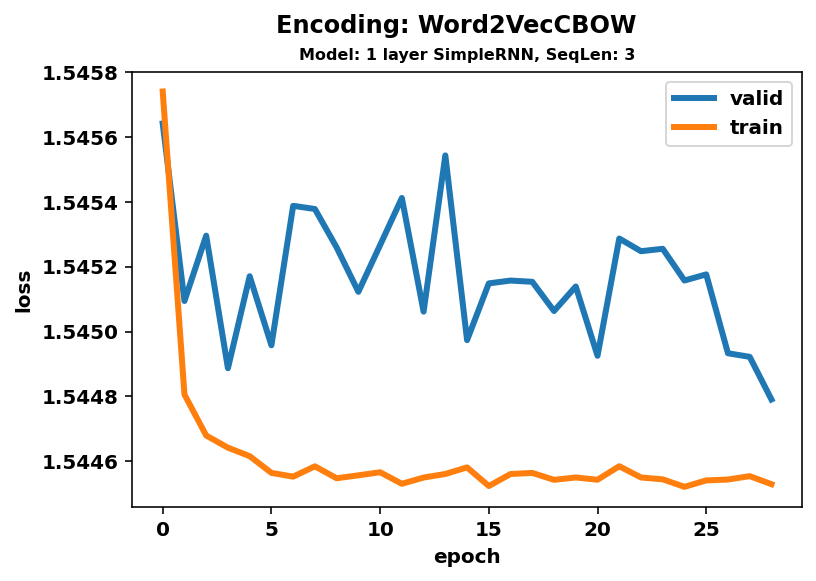

Test Loss: 0.19433, Runtime: 179s


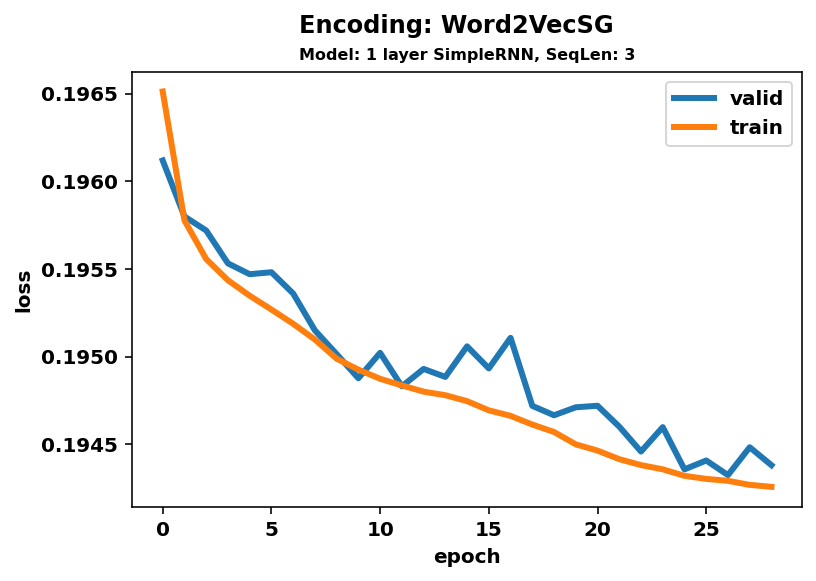

Test Loss: 3.82309, Runtime: 175s


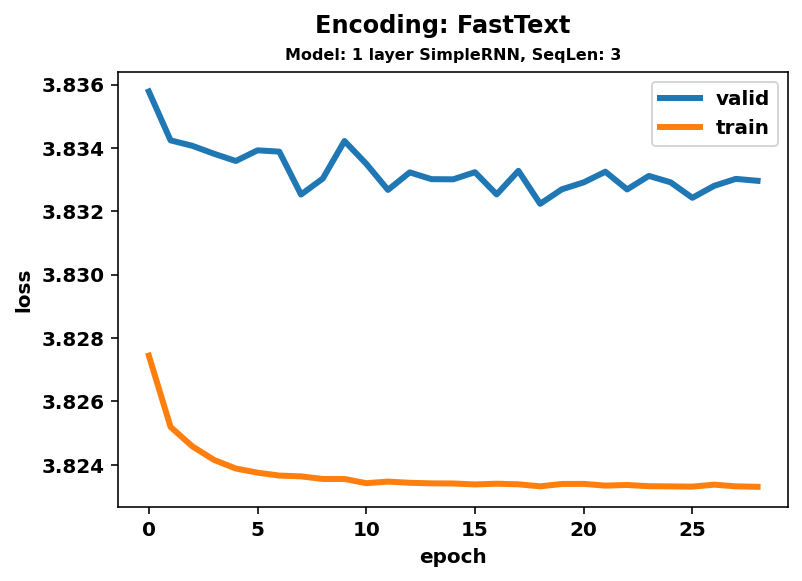

In [81]:
for encoding in results.keys():
    for model_name in results[encoding].keys():
        history = results1[encoding][model_name]['history']
        test_evaluation = results1[encoding][model_name]['test_evaluation']
        runtime = results1[encoding][model_name]['runtime']
        model = results1[encoding][model_name]['model']
        metrics = results1[encoding][model_name]['metrics']
        metric="loss"
        suptitle = f"Encoding: {encoding}"
        title = "Model: 1 layer SimpleRNN, SeqLen: 3"
        plot_metric(history, metric, suptitle, title)
        test_loss = round(test_evaluation,5)
        runtime = int(runtime)
        print(f"Test Loss: {test_loss}, Runtime: {runtime}s")
#         plt.text(5,np.array(history['loss'][1:]).max(), f"Test Loss: {test_loss}, Runtime: {runtime}s")
        filename = (suptitle+title).replace(":", "").replace(" ", "_")
#         plt.savefig("images/models_results/Experiment_1_Embeddings/"+filename+".pdf")
        plt.show()
        break

# Test 2
## SimpleRNN/LSTM/GRU
- model: Word2VecSG
- seq: 3

In [82]:
ENCODING_TYPES = ["Word2VecSG"]
MODELS = ["SimpleRNN_shallow","LSTM_shallow", "GRU_shallow"]

results2 = {}
songs = my_utils.build_sentences()
for encoding_type in ENCODING_TYPES:
    results2[encoding_type] = {}
    X_train, X_test, y_train, y_test = get_data(songs, encoding_type=encoding_type, seq_len=3)
    input_shape, output_shape = get_io_dimensions(X_train, y_train)
    for model_name in MODELS:
        model = get_model(model_name, input_shape, output_shape)
        history, test_evaluation, runtime, model, metrics = test_model(model, X_train, X_test, y_train, y_test)
        results2[encoding_type][model_name] = {}
        results2[encoding_type][model_name]['history'] = history
        results2[encoding_type][model_name]['test_evaluation'] = test_evaluation
        results2[encoding_type][model_name]['runtime'] = runtime
        results2[encoding_type][model_name]['model'] = model
        results2[encoding_type][model_name]['metrics'] = metrics


Epoch 1/30
4976/4976 [==============================] - 6s 1ms/step - loss: 0.2205 - val_loss: 0.1989
Epoch 2/30
4976/4976 [==============================] - 6s 1ms/step - loss: 0.1975 - val_loss: 0.1971
Epoch 3/30
4976/4976 [==============================] - 6s 1ms/step - loss: 0.1967 - val_loss: 0.1968
Epoch 4/30
4976/4976 [==============================] - 6s 1ms/step - loss: 0.1963 - val_loss: 0.1962
Epoch 5/30
4976/4976 [==============================] - 6s 1ms/step - loss: 0.1960 - val_loss: 0.1959
Epoch 6/30
4976/4976 [==============================] - 6s 1ms/step - loss: 0.1957 - val_loss: 0.1956
Epoch 7/30
4976/4976 [==============================] - 6s 1ms/step - loss: 0.1954 - val_loss: 0.1954
Epoch 8/30
4976/4976 [==============================] - 6s 1ms/step - loss: 0.1953 - val_loss: 0.1953
Epoch 9/30
4976/4976 [==============================] - 6s 1ms/step - loss: 0.1951 - val_loss: 0.1953
Epoch 10/30
4976/4976 [==============================] - 6s 1ms/step - loss: 0.19

In [85]:
def plot_metric(history, metric_name, suptitle, title):
    val_loss = history["val_" + metric_name][1:]
    plt.plot(val_loss, linewidth=3, label="valid")
    loss = history[metric_name][1:]
    plt.plot(loss, linewidth=3, label="train")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel(metric_name)
    plt.title(title, fontsize=8)
    plt.suptitle(suptitle, fontsize=12)

In [90]:
results[encoding].keys()

dict_keys(['SimpleRNN_shallow', 'LSTM_shallow', 'GRU_shallow'])

Test Loss: 0.19468, Runtime: 180s


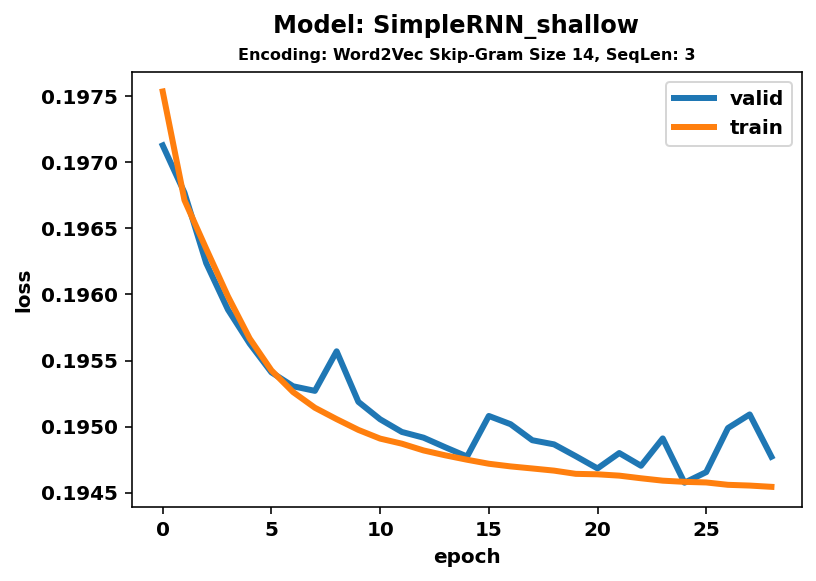

Test Loss: 0.18846, Runtime: 287s


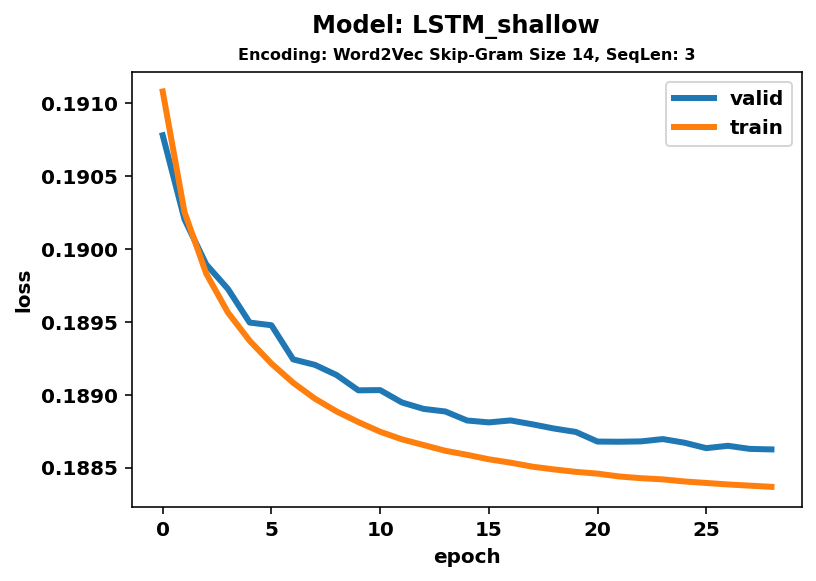

Test Loss: 0.18822, Runtime: 304s


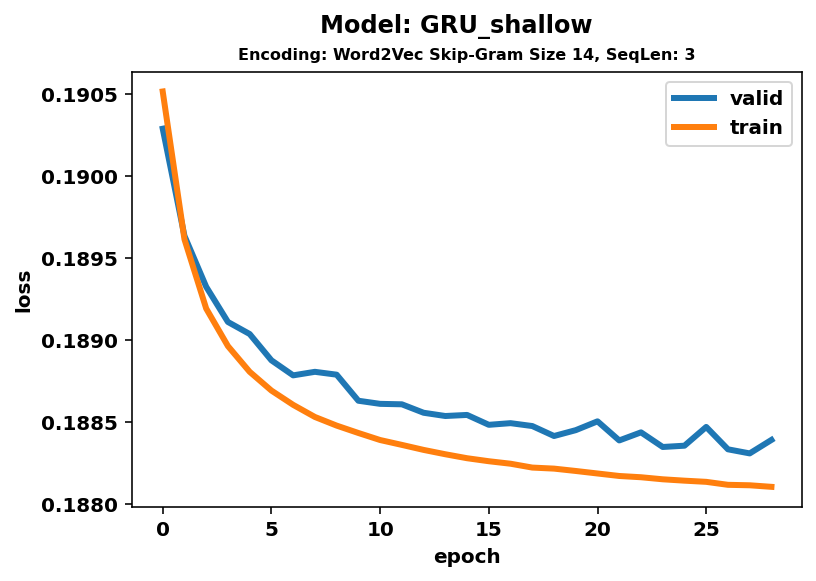

In [94]:
for encoding in results2.keys():
    for model_name in results2[encoding].keys():
        history = results2[encoding][model_name]['history']
        test_evaluation = results2[encoding][model_name]['test_evaluation']
        runtime = results2[encoding][model_name]['runtime']
        metric="loss"
        suptitle = f"Model: {model_name}"
        title = "Encoding: Word2Vec Skip-Gram Size 14, SeqLen: 3"
        plot_metric(history, metric, suptitle, title)
        test_loss = round(test_evaluation,5)
        runtime = int(runtime)
        print(f"Test Loss: {test_loss}, Runtime: {runtime}s")
#         plt.text(5,np.array(history['loss'][1:]).max(), f"Test Loss: {test_loss}, Runtime: {runtime}s")
        filename = (suptitle+title).replace(":", "").replace(" ", "_")
        plt.savefig("images/models_results/Experiment_2_Models/"+filename+".pdf")
        plt.show()

# Test 3
## Seq size 3/7/15
- model: Word2VecSG
- model: LSTM_shallow

In [97]:
ENCODING_TYPES = ["Word2VecSG"]
MODELS = ["LSTM_shallow"]
SEQ_LENGTGHS = [3,7,15]

results3 = {}
songs = my_utils.build_sentences()
for seq_len in SEQ_LENGTGHS:
    results3[seq_len] = {}
    encoding_type = ENCODING_TYPES[0]
    X_train, X_test, y_train, y_test = get_data(songs, encoding_type=encoding_type, seq_len=seq_len)
    input_shape, output_shape = get_io_dimensions(X_train, y_train)
    model_name = MODELS[0]
    model = get_model(model_name, input_shape, output_shape)
    history, test_evaluation, runtime, model, metrics = test_model(model, X_train, X_test, y_train, y_test)
    results3[seq_len]['history'] = history
    results3[seq_len]['test_evaluation'] = test_evaluation
    results3[seq_len]['runtime'] = runtime
    results3[seq_len]['model'] = model
    results3[seq_len]['metrics'] = metrics


Epoch 1/30
4976/4976 [==============================] - 10s 2ms/step - loss: 0.1986 - val_loss: 0.1901
Epoch 2/30
4976/4976 [==============================] - 10s 2ms/step - loss: 0.1892 - val_loss: 0.1888
Epoch 3/30
4976/4976 [==============================] - 9s 2ms/step - loss: 0.1883 - val_loss: 0.1881
Epoch 4/30
4976/4976 [==============================] - 10s 2ms/step - loss: 0.1878 - val_loss: 0.1878
Epoch 5/30
4976/4976 [==============================] - 10s 2ms/step - loss: 0.1875 - val_loss: 0.1876
Epoch 6/30
4976/4976 [==============================] - 10s 2ms/step - loss: 0.1873 - val_loss: 0.1874
Epoch 7/30
4976/4976 [==============================] - 10s 2ms/step - loss: 0.1871 - val_loss: 0.1873
Epoch 8/30
4976/4976 [==============================] - 9s 2ms/step - loss: 0.1870 - val_loss: 0.1872
Epoch 9/30
4976/4976 [==============================] - 10s 2ms/step - loss: 0.1869 - val_loss: 0.1871
Epoch 10/30
4976/4976 [==============================] - 10s 2ms/step - lo


Epoch 1/30
4975/4975 [==============================] - 16s 3ms/step - loss: 0.1943 - val_loss: 0.1844
Epoch 2/30
4975/4975 [==============================] - 15s 3ms/step - loss: 0.1831 - val_loss: 0.1831
Epoch 3/30
4975/4975 [==============================] - 15s 3ms/step - loss: 0.1823 - val_loss: 0.1826
Epoch 4/30
4975/4975 [==============================] - 15s 3ms/step - loss: 0.1819 - val_loss: 0.1824
Epoch 5/30
4975/4975 [==============================] - 15s 3ms/step - loss: 0.1817 - val_loss: 0.1821
Epoch 6/30
4975/4975 [==============================] - 15s 3ms/step - loss: 0.1815 - val_loss: 0.1820
Epoch 7/30
4975/4975 [==============================] - 15s 3ms/step - loss: 0.1814 - val_loss: 0.1819
Epoch 8/30
4975/4975 [==============================] - 15s 3ms/step - loss: 0.1813 - val_loss: 0.1818
Epoch 9/30
4975/4975 [==============================] - 15s 3ms/step - loss: 0.1812 - val_loss: 0.1817
Epoch 10/30
4975/4975 [==============================] - 15s 3ms/step - 


Epoch 1/30
4903/4903 [==============================] - 28s 6ms/step - loss: 0.1851 - val_loss: 0.1758
Epoch 2/30
4903/4903 [==============================] - 25s 5ms/step - loss: 0.1748 - val_loss: 0.1744
Epoch 3/30
4903/4903 [==============================] - 26s 5ms/step - loss: 0.1739 - val_loss: 0.1738
Epoch 4/30
4903/4903 [==============================] - 28s 6ms/step - loss: 0.1735 - val_loss: 0.1736
Epoch 5/30
4903/4903 [==============================] - 26s 5ms/step - loss: 0.1732 - val_loss: 0.1733
Epoch 6/30
4903/4903 [==============================] - 28s 6ms/step - loss: 0.1731 - val_loss: 0.1731
Epoch 7/30
4903/4903 [==============================] - 28s 6ms/step - loss: 0.1730 - val_loss: 0.1731
Epoch 8/30
4903/4903 [==============================] - 28s 6ms/step - loss: 0.1729 - val_loss: 0.1729
Epoch 9/30
4903/4903 [==============================] - 27s 6ms/step - loss: 0.1728 - val_loss: 0.1728
Epoch 10/30
4903/4903 [==============================] - 27s 6ms/step - 

In [85]:
def plot_metric(history, metric_name, suptitle, title):
    val_loss = history["val_" + metric_name]
    plt.plot(val_loss, linewidth=3, label="valid")
    loss = history[metric_name]
    plt.plot(loss, linewidth=3, label="train")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel(metric_name)
    plt.title(title, fontsize=8)
    plt.suptitle(suptitle, fontsize=12)

Test Loss: 0.18651, Runtime: 299s


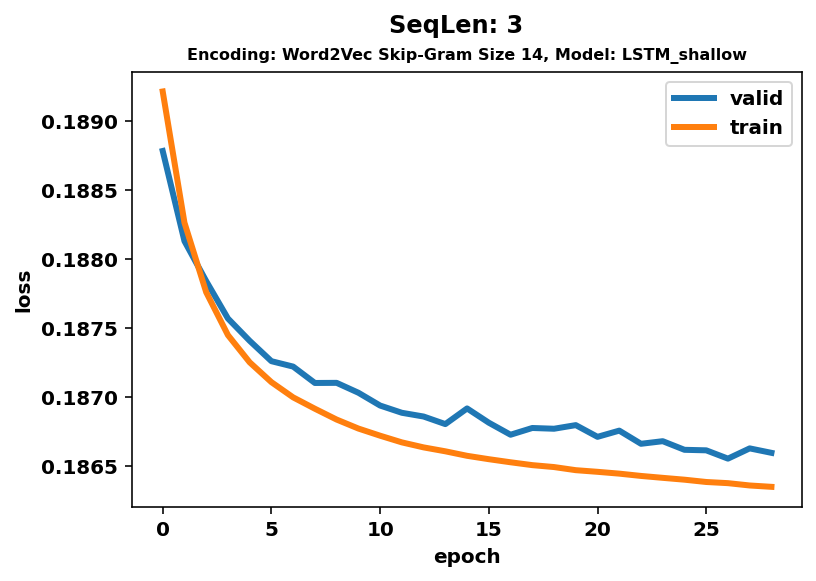

Test Loss: 0.18111, Runtime: 454s


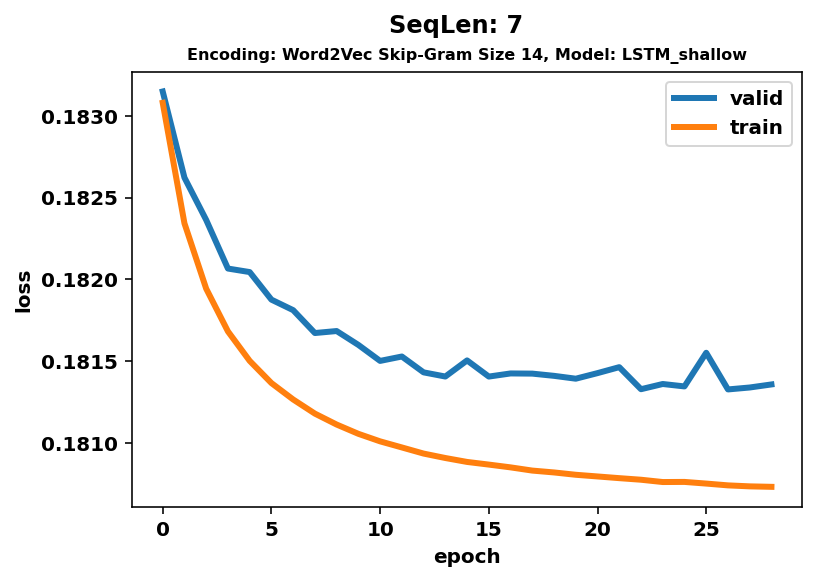

Test Loss: 0.1718, Runtime: 813s


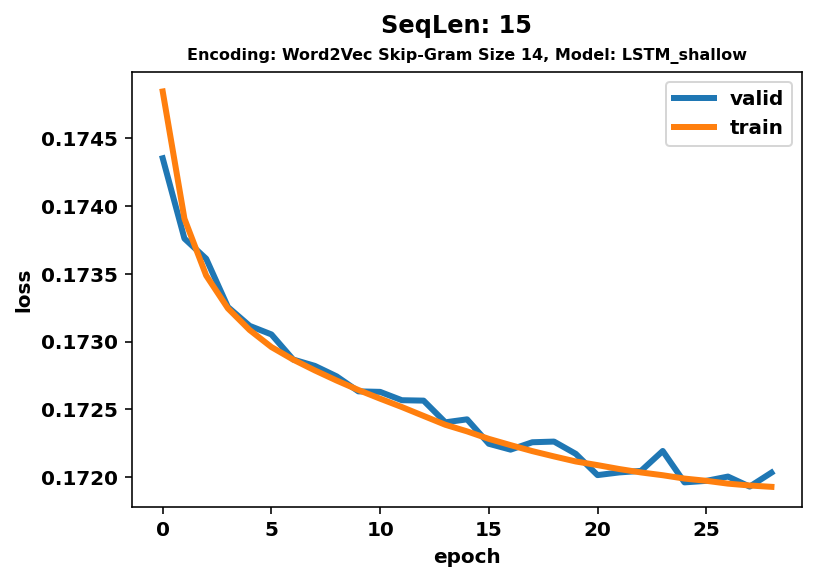

In [100]:
for seq_len in results3.keys():
    history = results3[seq_len]['history']
    test_evaluation = results3[seq_len]['test_evaluation']
    runtime = results3[seq_len]['runtime']
    metric="loss"
    suptitle = f"SeqLen: {seq_len}"
    title = "Encoding: Word2Vec Skip-Gram Size 14, Model: LSTM_shallow"
    plot_metric(history, metric, suptitle, title)
    test_loss = round(test_evaluation,5)
    runtime = int(runtime)
    print(f"Test Loss: {test_loss}, Runtime: {runtime}s")
#         plt.text(5,np.array(history['loss'][1:]).max(), f"Test Loss: {test_loss}, Runtime: {runtime}s")
    filename = (suptitle+title).replace(":", "").replace(" ", "_")
    plt.savefig("images/models_results/Experiment_3_SeqLengths/"+filename+".pdf")
    plt.show()

# Distribution with Tanh Activacion Function

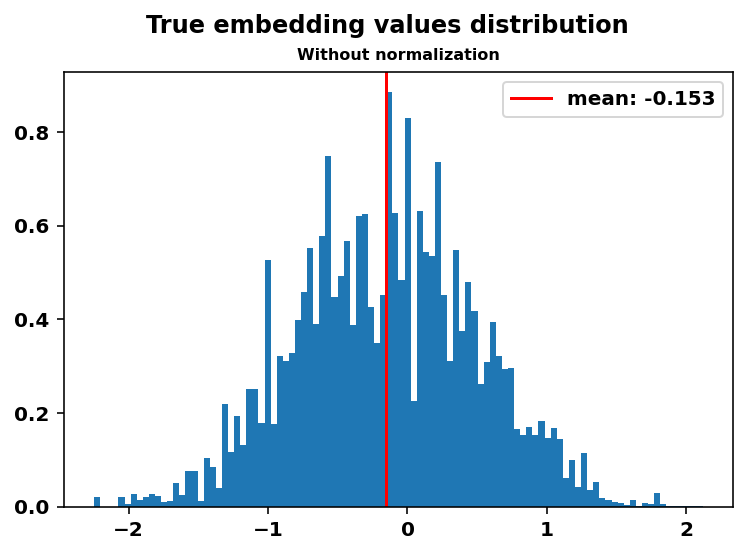

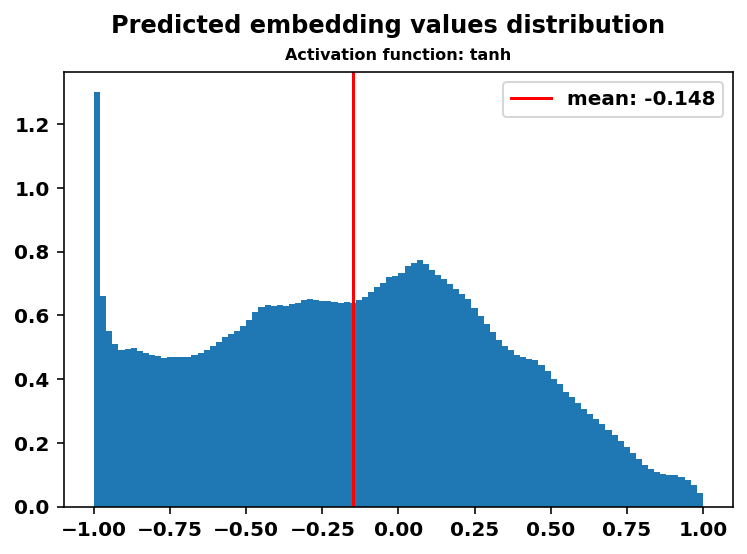

In [152]:
plt.hist(y_train.reshape(-1), density=True, bins=100)
mean = y_train.reshape(-1).mean()
plt.axvline(mean, c='r', label="mean: %.3f"%mean)
suptitle = "True embedding values distribution"
plt.suptitle(suptitle)
plt.title("Without normalization", fontsize=8)
plt.legend()
plt.savefig("images/models_results/Value_Distribution_With_Activation/"+suptitle.replace(" ","_")+".pdf")
plt.show()
plt.hist(pred.reshape(-1), density=True, bins=100)
mean = pred.reshape(-1).mean()
plt.axvline(mean, c='r', label="mean: %.3f"%mean)
suptitle = "Predicted embedding values distribution"
plt.suptitle(suptitle)
plt.title("Activation function: tanh", fontsize=8)
plt.legend()
plt.savefig("images/models_results/Value_Distribution_With_Activation/"+suptitle.replace(" ","_")+".pdf")
plt.show()

# Test 4
## Word2VecCBOW/Word2VecSG/FastText
- model: LSTM_shallow
- seq: 15
- activation: None

In [159]:
ENCODING_TYPES = ["Word2VecCBOW", "Word2VecSG", "FastText"]
MODELS = ["LSTM_shallow"]

results4 = {}
songs = my_utils.build_sentences()
for encoding_type in ENCODING_TYPES:
    results4[encoding_type] = {}
    X_train, X_test, y_train, y_test = get_data(songs, encoding_type=encoding_type, seq_len=15)
    input_shape, output_shape = get_io_dimensions(X_train, y_train)
    for model_name in MODELS:
        model = get_model(model_name, input_shape, output_shape, activation=None)
        history, test_evaluation, runtime, model, metrics = test_model(model, X_train, X_test, y_train, y_test)
        results4[encoding_type][model_name] = {}
        results4[encoding_type][model_name]['history'] = history
        results4[encoding_type][model_name]['test_evaluation'] = test_evaluation
        results4[encoding_type][model_name]['runtime'] = runtime
        results4[encoding_type][model_name]['model'] = model
        results4[encoding_type][model_name]['metrics'] = metrics


Epoch 1/30
4895/4903 [============================>.] - ETA: 0s - loss: 1.3734
epoch 0,	loss 1.3731,	val_loss 1.2419	mean_cos_dist 0.3507	val_mean_cos_dist 0.3399.
4903/4903 [==============================] - 23s 5ms/step - loss: 1.3731 - val_loss: 1.2419
Epoch 2/30
4900/4903 [============================>.] - ETA: 0s - loss: 1.2369
epoch 1,	loss 1.2369,	val_loss 1.2321	mean_cos_dist 0.3456	val_mean_cos_dist 0.3363.
4903/4903 [==============================] - 22s 4ms/step - loss: 1.2369 - val_loss: 1.2321
Epoch 3/30
4900/4903 [============================>.] - ETA: 0s - loss: 1.2322
epoch 2,	loss 1.2322,	val_loss 1.2308	mean_cos_dist 0.3452	val_mean_cos_dist 0.3371.
4903/4903 [==============================] - 23s 5ms/step - loss: 1.2322 - val_loss: 1.2308
Epoch 4/30
4903/4903 [==============================] - ETA: 0s - loss: 1.2300
epoch 3,	loss 1.2300,	val_loss 1.2280	mean_cos_dist 0.3439	val_mean_cos_dist 0.3353.
4903/4903 [==============================] - 22s 5ms/step - loss: 1


Epoch 1/30
4900/4903 [============================>.] - ETA: 0s - loss: 0.1852
epoch 0,	loss 0.1852,	val_loss 0.1747	mean_cos_dist 0.2317	val_mean_cos_dist 0.2245.
4903/4903 [==============================] - 24s 5ms/step - loss: 0.1852 - val_loss: 0.1747
Epoch 2/30
4899/4903 [============================>.] - ETA: 0s - loss: 0.1741
epoch 1,	loss 0.1741,	val_loss 0.1737	mean_cos_dist 0.2301	val_mean_cos_dist 0.2230.
4903/4903 [==============================] - 23s 5ms/step - loss: 0.1741 - val_loss: 0.1737
Epoch 3/30
4896/4903 [============================>.] - ETA: 0s - loss: 0.1733
epoch 2,	loss 0.1733,	val_loss 0.1730	mean_cos_dist 0.2296	val_mean_cos_dist 0.2224.
4903/4903 [==============================] - 23s 5ms/step - loss: 0.1733 - val_loss: 0.1730
Epoch 4/30
4896/4903 [============================>.] - ETA: 0s - loss: 0.1728
epoch 3,	loss 0.1728,	val_loss 0.1727	mean_cos_dist 0.2281	val_mean_cos_dist 0.2221.
4903/4903 [==============================] - 24s 5ms/step - loss: 0


Epoch 1/30
4900/4903 [============================>.] - ETA: 0s - loss: 3.2860
epoch 0,	loss 3.2858,	val_loss 2.9437	mean_cos_dist 0.3786	val_mean_cos_dist 0.3689.
4903/4903 [==============================] - 23s 5ms/step - loss: 3.2858 - val_loss: 2.9437
Epoch 2/30
4897/4903 [============================>.] - ETA: 0s - loss: 2.9205
epoch 1,	loss 2.9204,	val_loss 2.9051	mean_cos_dist 0.3711	val_mean_cos_dist 0.3632.
4903/4903 [==============================] - 22s 5ms/step - loss: 2.9204 - val_loss: 2.9051
Epoch 3/30
4897/4903 [============================>.] - ETA: 0s - loss: 2.9036
epoch 2,	loss 2.9036,	val_loss 2.9004	mean_cos_dist 0.3710	val_mean_cos_dist 0.3637.
4903/4903 [==============================] - 23s 5ms/step - loss: 2.9036 - val_loss: 2.9004
Epoch 4/30
4895/4903 [============================>.] - ETA: 0s - loss: 2.8971
epoch 3,	loss 2.8970,	val_loss 2.8948	mean_cos_dist 0.3689	val_mean_cos_dist 0.3620.
4903/4903 [==============================] - 22s 4ms/step - loss: 2

In [160]:
def plot_metric(history, metric_name, suptitle, title):
    val_loss = history["val_" + metric_name][1:]
    plt.plot(val_loss, linewidth=3, label="valid")
    loss = history[metric_name][1:]
    plt.plot(loss, linewidth=3, label="train")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel(metric_name)
    plt.title(title, fontsize=8)
    plt.suptitle(suptitle, fontsize=12)

Test Loss: 1.2118, Runtime: 694s


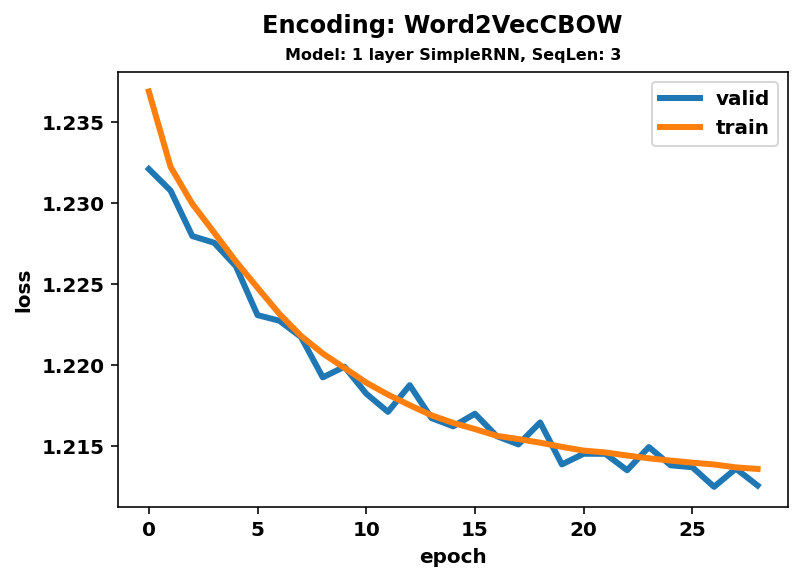

Test Loss: 0.17061, Runtime: 682s


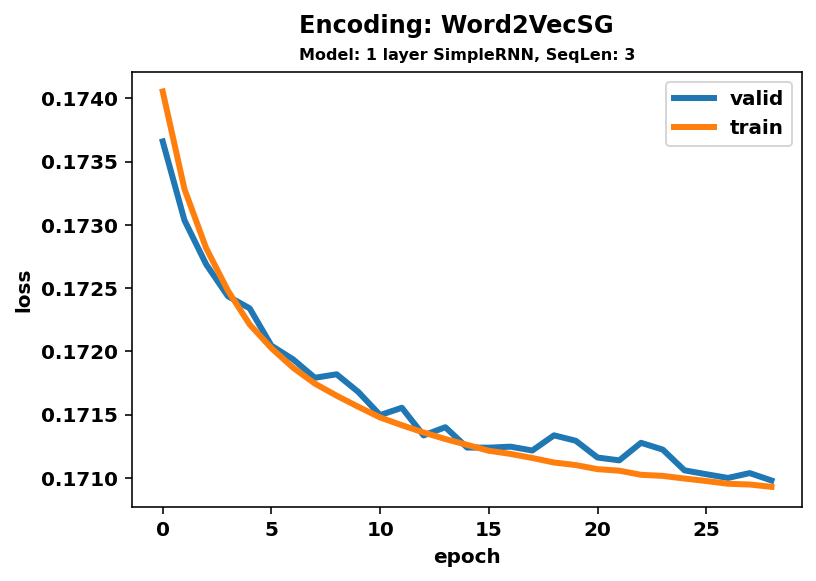

Test Loss: 2.85769, Runtime: 673s


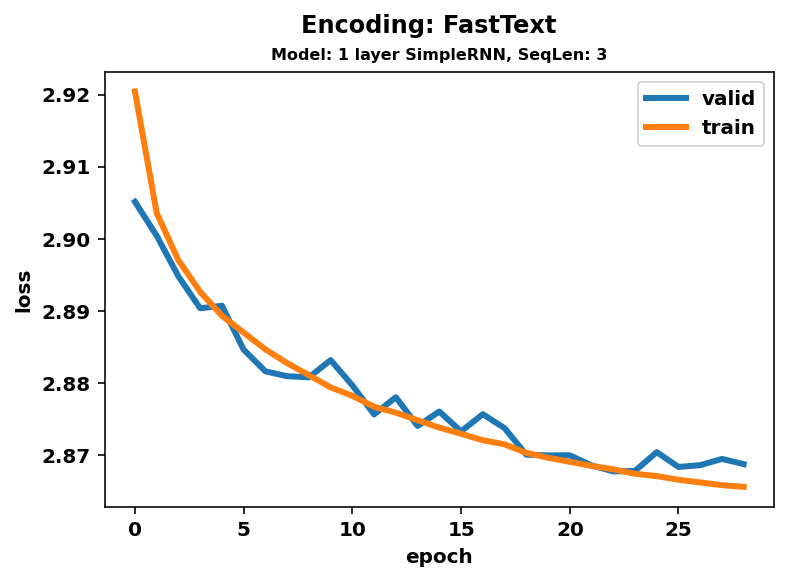

In [161]:
for encoding in results4.keys():
    for model_name in results4[encoding].keys():
        history = results4[encoding][model_name]['history']
        test_evaluation = results4[encoding][model_name]['test_evaluation']
        runtime = results4[encoding][model_name]['runtime']
        metric="loss"
        suptitle = f"Encoding: {encoding}"
        title = "Model: 1 layer SimpleRNN, SeqLen: 3"
        plot_metric(history, metric, suptitle, title)
        test_loss = round(test_evaluation,5)
        runtime = int(runtime)
        print(f"Test Loss: {test_loss}, Runtime: {runtime}s")
        filename = (suptitle+title).replace(":", "").replace(" ", "_")
        plt.savefig("images/models_results/Experiment_4_Embeddings_No_Activation/"+filename+".pdf")
        plt.show()
        break

# Distribution without Activation Function

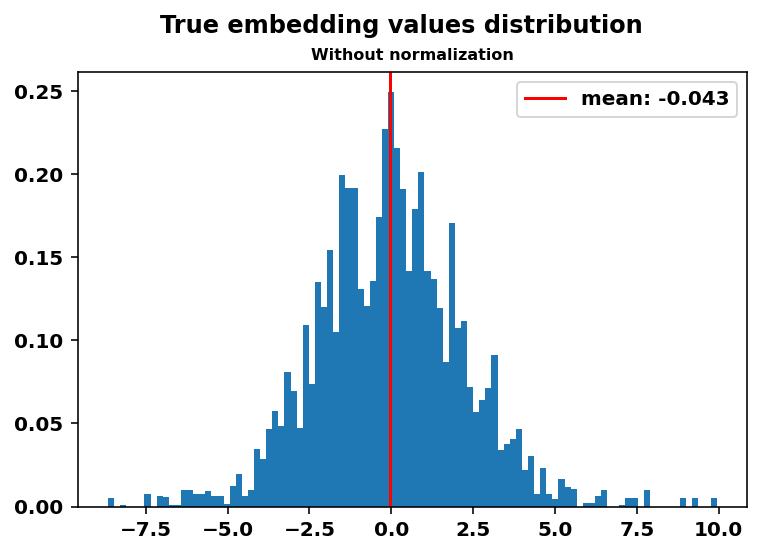

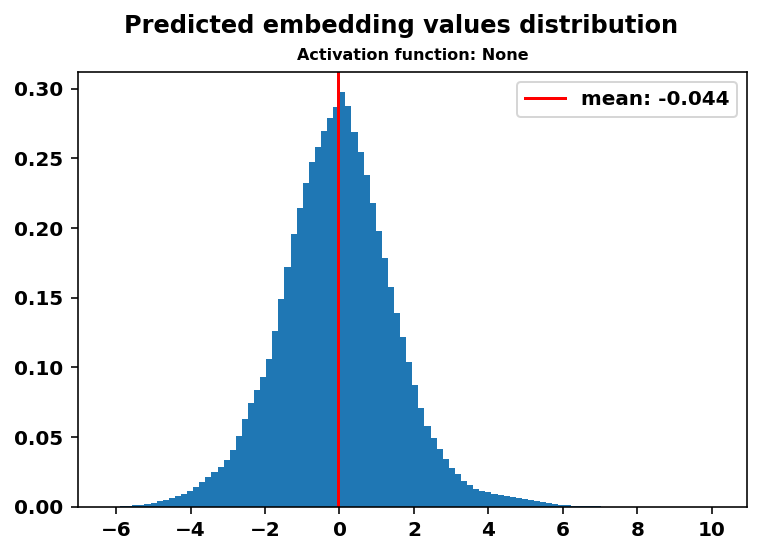

In [164]:
plt.hist(y_train.reshape(-1), density=True, bins=100)
mean = y_train.reshape(-1).mean()
plt.axvline(mean, c='r', label="mean: %.3f"%mean)
suptitle = "True embedding values distribution"
plt.suptitle(suptitle)
plt.title("Without normalization", fontsize=8)
plt.legend()
plt.savefig("images/models_results/Value_Distribution_No_Activation/"+suptitle.replace(" ","_")+".pdf")
plt.show()

pred = model.predict(X_train)
plt.hist(pred.reshape(-1), density=True, bins=100)
mean = pred.reshape(-1).mean()
plt.axvline(mean, c='r', label="mean: %.3f"%mean)
suptitle = "Predicted embedding values distribution"
plt.suptitle(suptitle)
plt.title("Activation function: None", fontsize=8)
plt.legend()
plt.savefig("images/models_results/Value_Distribution_No_Activation/"+suptitle.replace(" ","_")+".pdf")
plt.show()

# Test 5
## GRU32/LSTM32/GRU3264/LSTM3264
- embedding: Word2VecSG
- seq: 15
- activation: None

In [28]:
ENCODING_TYPES = ["Word2VecSG"]
MODELS = ["GRU32","LSTM32","GRU3264","LSTM3264"]

results5 = {}
songs = my_utils.build_sentences()
for encoding_type in ENCODING_TYPES:
    results5[encoding_type] = {}
    X_train, X_test, y_train, y_test = get_data(songs, encoding_type=encoding_type, seq_len=15)
    input_shape, output_shape = get_io_dimensions(X_train, y_train)
    for model_name in MODELS:
        model = get_model(model_name, input_shape, output_shape, activation=None)
        history, test_evaluation, runtime, model, metrics = test_model(model, X_train, X_test, y_train, y_test)
        results5[encoding_type][model_name] = {}
        results5[encoding_type][model_name]['history'] = history
        results5[encoding_type][model_name]['test_evaluation'] = test_evaluation
        results5[encoding_type][model_name]['runtime'] = runtime
        results5[encoding_type][model_name]['model'] = model
        results5[encoding_type][model_name]['metrics'] = metrics


Epoch 1/30
4901/4903 [============================>.] - ETA: 0s - loss: 0.1877
epoch 0,	loss 0.1877,	val_loss 0.1742	mean_cos_dist 0.2286	val_mean_cos_dist 0.2256.
4903/4903 [==============================] - 16s 3ms/step - loss: 0.1877 - val_loss: 0.1742
Epoch 2/30
4897/4903 [============================>.] - ETA: 0s - loss: 0.1802
epoch 1,	loss 0.1802,	val_loss 0.1732	mean_cos_dist 0.2281	val_mean_cos_dist 0.2247.
4903/4903 [==============================] - 16s 3ms/step - loss: 0.1802 - val_loss: 0.1732
Epoch 3/30
4888/4903 [============================>.] - ETA: 0s - loss: 0.1795
epoch 2,	loss 0.1795,	val_loss 0.1724	mean_cos_dist 0.2268	val_mean_cos_dist 0.2234.
4903/4903 [==============================] - 16s 3ms/step - loss: 0.1795 - val_loss: 0.1724
Epoch 4/30
4903/4903 [==============================] - ETA: 0s - loss: 0.1790
epoch 3,	loss 0.1790,	val_loss 0.1724	mean_cos_dist 0.2258	val_mean_cos_dist 0.2229.
4903/4903 [==============================] - 16s 3ms/step - loss: 0

In [29]:
results5


{'Word2VecSG': {'GRU32': {'history': {'loss': [0.18766401708126068,
     0.1802050620317459,
     0.17950227856636047,
     0.17902550101280212,
     0.17872394621372223,
     0.17838194966316223,
     0.1781562715768814,
     0.17797571420669556,
     0.1778011918067932,
     0.1776689887046814,
     0.17757807672023773,
     0.17742793262004852,
     0.1773918867111206,
     0.17730776965618134,
     0.1771790087223053,
     0.17713382840156555,
     0.17700448632240295,
     0.1770276129245758,
     0.17696018517017365,
     0.17690923810005188,
     0.1768561452627182,
     0.17678940296173096,
     0.1768094152212143,
     0.17678743600845337,
     0.1767023503780365,
     0.1766778826713562,
     0.176675483584404,
     0.17658589780330658,
     0.17663970589637756,
     0.17649786174297333],
    'val_loss': [0.17417240142822266,
     0.1732417345046997,
     0.1724289357662201,
     0.1724076122045517,
     0.17190736532211304,
     0.17134276032447815,
     0.17098701000213623,

In [30]:
def plot_metric(history, metric_name, suptitle, title):
    val_loss = history["val_" + metric_name][1:]
    plt.plot(val_loss, linewidth=3, label="valid")
    loss = history[metric_name][1:]
    plt.plot(loss, linewidth=3, label="train")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel(metric_name)
    plt.title(title, fontsize=8)
    plt.suptitle(suptitle, fontsize=12)

In [34]:
results5['Word2VecSG']['GRU32'].keys()

dict_keys(['history', 'test_evaluation', 'runtime', 'model', 'metrics'])

Model: GRU32
Encoding: Word2Vec Skip-Gram Size 14, SeqLen: 15
Test Loss: 0.16949, Runtime: 480s
Min val_loss: 0.1695074886083603, Min val_mean_cos_dist: 0.21989615185186268s


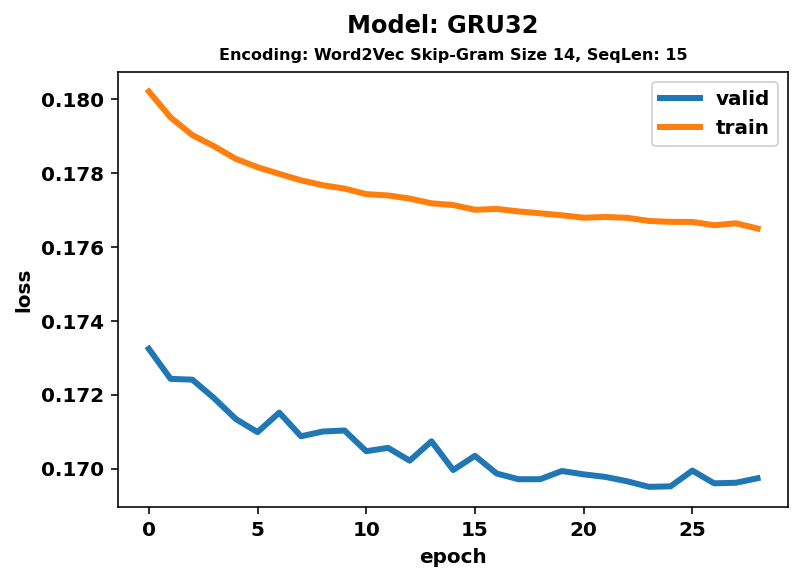

Model: GRU32
Encoding: Word2Vec Skip-Gram Size 14, SeqLen: 15
Test Loss: 0.16949, Runtime: 480s
Min val_loss: 0.1695074886083603, Min val_mean_cos_dist: 0.21989615185186268s


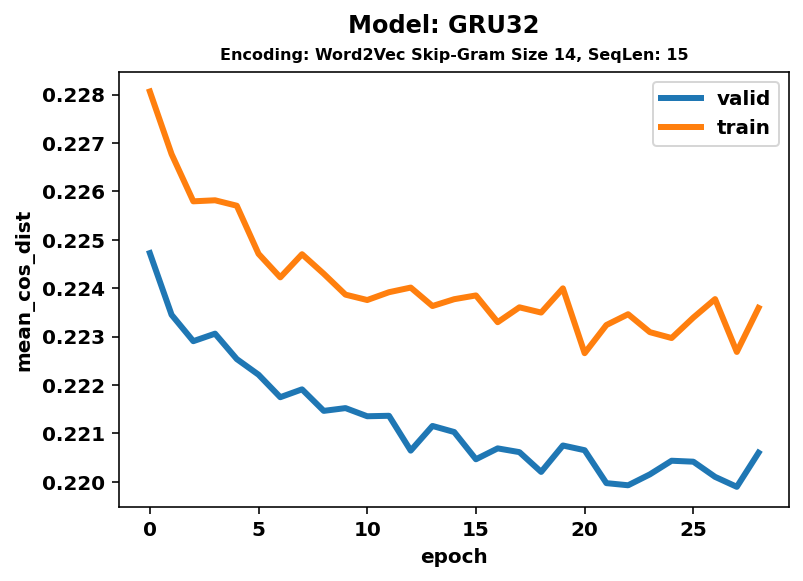

Model: LSTM32
Encoding: Word2Vec Skip-Gram Size 14, SeqLen: 15
Test Loss: 0.1683, Runtime: 558s
Min val_loss: 0.16843043267726898, Min val_mean_cos_dist: 0.2187423534980044s


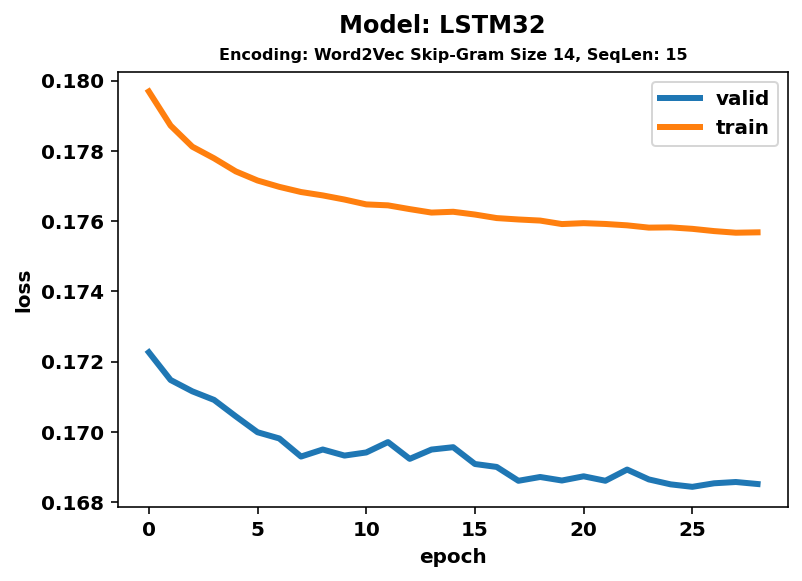

Model: LSTM32
Encoding: Word2Vec Skip-Gram Size 14, SeqLen: 15
Test Loss: 0.1683, Runtime: 558s
Min val_loss: 0.16843043267726898, Min val_mean_cos_dist: 0.2187423534980044s


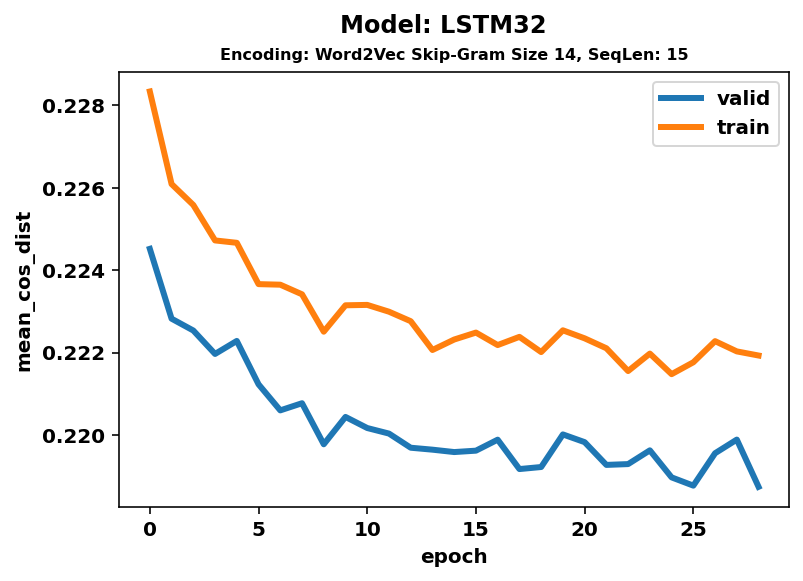

Model: GRU3264
Encoding: Word2Vec Skip-Gram Size 14, SeqLen: 15
Test Loss: 0.16778, Runtime: 764s
Min val_loss: 0.16770364344120026, Min val_mean_cos_dist: 0.21777736493200064s


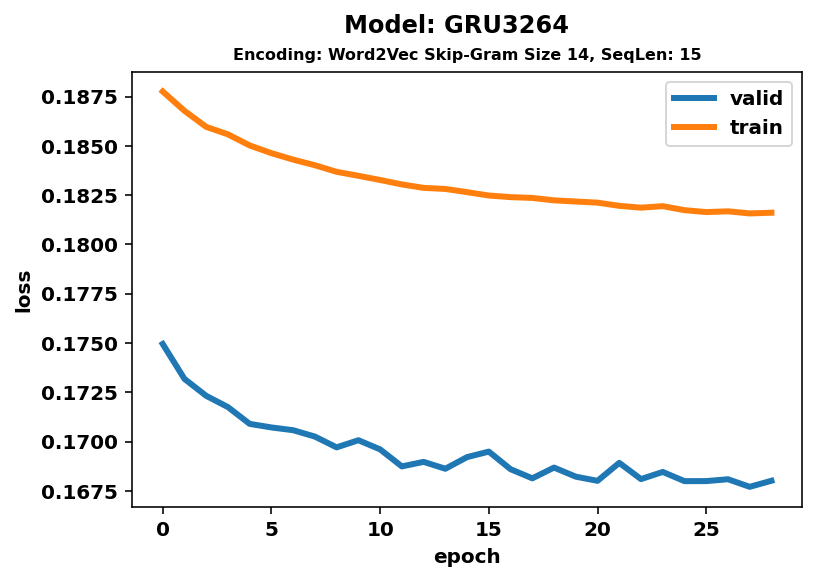

Model: GRU3264
Encoding: Word2Vec Skip-Gram Size 14, SeqLen: 15
Test Loss: 0.16778, Runtime: 764s
Min val_loss: 0.16770364344120026, Min val_mean_cos_dist: 0.21777736493200064s


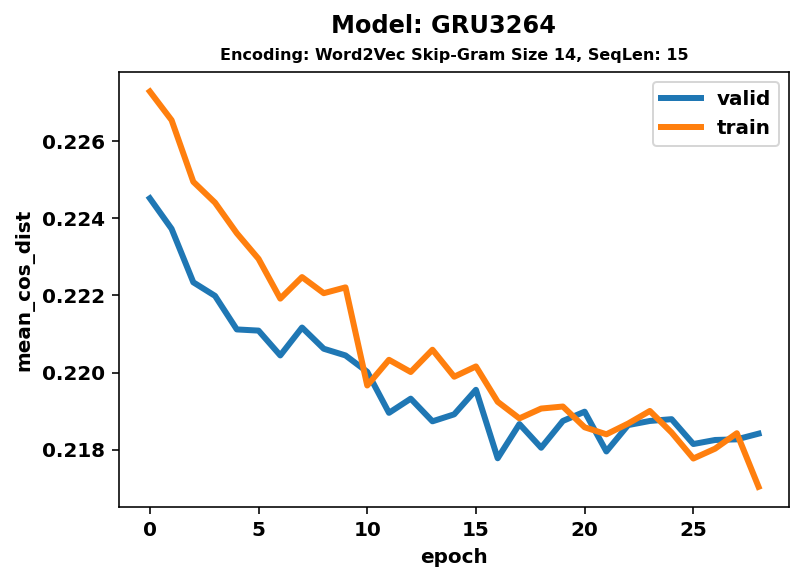

Model: LSTM3264
Encoding: Word2Vec Skip-Gram Size 14, SeqLen: 15
Test Loss: 0.16705, Runtime: 820s
Min val_loss: 0.1660938411951065, Min val_mean_cos_dist: 0.2150395576953888s


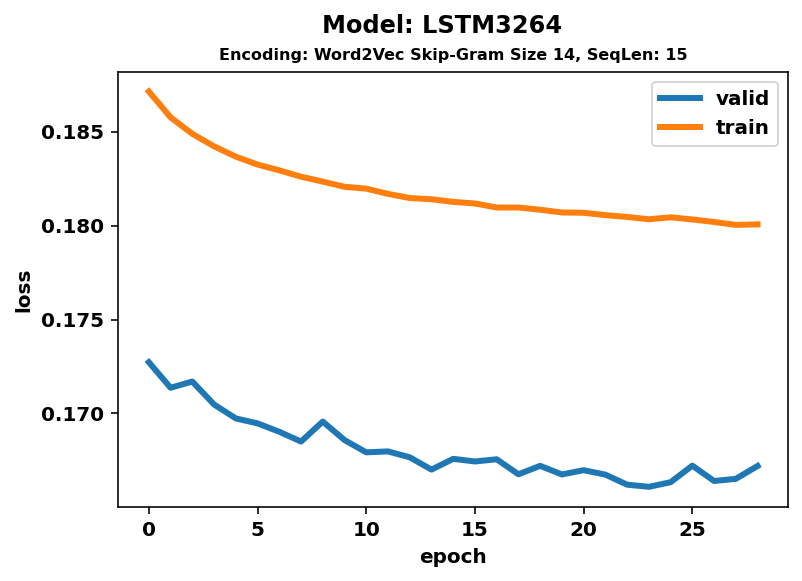

Model: LSTM3264
Encoding: Word2Vec Skip-Gram Size 14, SeqLen: 15
Test Loss: 0.16705, Runtime: 820s
Min val_loss: 0.1660938411951065, Min val_mean_cos_dist: 0.2150395576953888s


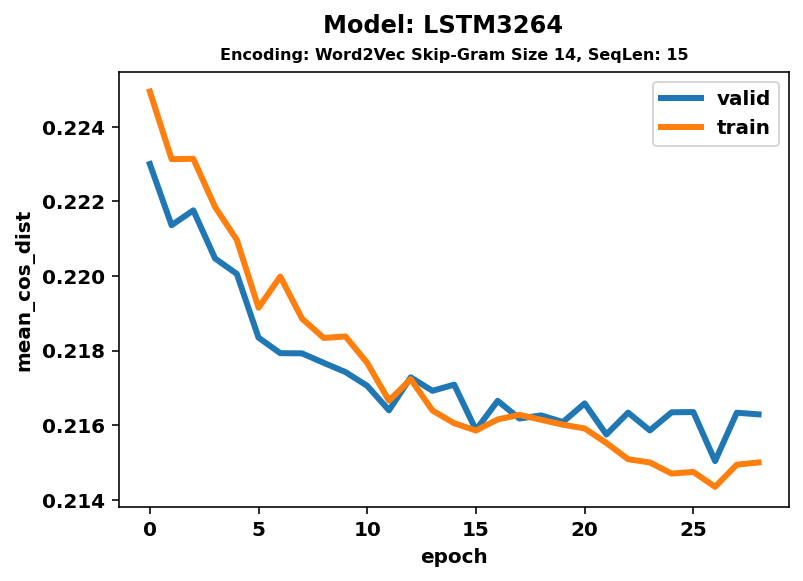

In [77]:
for encoding in results5.keys():
    for model_name in results5[encoding].keys():
        history = results5[encoding][model_name]['history']
        test_evaluation = results5[encoding][model_name]['test_evaluation']
        runtime = results5[encoding][model_name]['runtime']
        model = results5[encoding][model_name]['model']
        metrics = results5[encoding][model_name]['metrics']

        suptitle = f"Model: {model_name}"
        title = "Encoding: Word2Vec Skip-Gram Size 14, SeqLen: 15"
        history.update(metrics.mean_cos_dist)
        history.update(metrics.val_mean_cos_dist)
        for metric_name in ['loss', 'mean_cos_dist']:
            plot_metric(history, metric_name, suptitle, title)
            test_loss = round(test_evaluation,5)
            runtime = int(runtime)
            print(suptitle)
            print(title)
            print(f"Test Loss: {test_loss}, Runtime: {runtime}s")
            print(f"Min val_loss: {min(history['val_loss'])}, Min val_mean_cos_dist: {min(history['val_mean_cos_dist'])}s")
            filename = (suptitle+title).replace(":", "").replace(" ", "_")
            plt.savefig("images/models_results/Experiment_5_Deep_Models/"+filename+"_"+metric_name+".pdf",bbox_inches='tight')
            plt.show()
        

In [74]:
, 

(0.1660938411951065, 0.2150395576953888)

In [61]:
import tensorflow as tf 
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [62]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [ ]:
# model.add(LSTM(units=50, return sequences=True, ) input_shape=(X. shape [1], X. shape [2] ) ) ) 
# model.add(Dropout(0.2)) 
# model.add(LSTM(units=50, return_sequences=True)) 
# model.add(Dropout(0.2)) 
# model.add(LSTM(units=50)) 
# model.add(Dropout(0.2)) 
# model.add(Dense(units=1)) 
# model.compile (optimizer= 'adam', loss = 'mean squared error', metrics ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
t0 = time.time
history = model.fit(x, y, epochs=10,  batch_size = 250, callbacks=[es], verbose=1)
t1 = time.time() 
print('Runtime: %.2f s '%(t1-t0))

In [ ]:
plt.figure(figsize=(8,4))
p1t.semilogy(history.history $[\text { ' } 1 \text { oss } ']$ ) 
plt.xlabel('epoch'); plt.ylabel('loss') 
plt.savefig('tclab 10 ss $.$ png ' ) 
model.save('model. h 5 ')

In [20]:
model = Sequential(
    [
        LSTM(128, activation='relu', return_sequences=False, input_shape=X_train.shape[1:]),
        Dense(y_train.shape[1])
    ]
)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               72704     
_________________________________________________________________
dense_3 (Dense)              (None, 13)                1677      
Total params: 74,381
Trainable params: 74,381
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
import tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

class Metrics(Callback):
    def __init__(self, tr_data, val_data):
        self.validation_data = val_data    
        self.train_data = tr_data    
    
    def cosine_distance_sum(self, A, B):
        return sum([1.0 - np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(A, B)])

    def mean_cos_dist_sum(self, X_vali, y_vali):
        y_pred = model.predict(X_vali)
        return self.cosine_distance_sum(y_pred, y_vali)/y_vali.shape[0]
        
    def on_train_begin(self, logs={}):
        self.mean_cos_dist = []      
        self.val_mean_cos_dist = []       
        
    def on_epoch_end(self, epoch, logs={}):
        score = self.mean_cos_dist_sum(self.train_data[0][:1000], self.train_data[1][:1000])
        score_val = self.mean_cos_dist_sum(self.validation_data[0][:1000], self.validation_data[1][:1000])
        self.mean_cos_dist.append(score)
        self.val_mean_cos_dist.append(score_val)
        print('epoch {},\tloss {:3.4f},\tval_loss {:3.4f}\tmean_cos_dist {:3.4f}\tval_mean_cos_dist {:3.4f}.'.format(
            epoch, logs['loss'], logs['val_loss'], score, score_val))
        
    def on_train_end(self, logs={}):
        self.mean_cos_dist = {'mean_cos_dist': self.mean_cos_dist}    
        self.val_mean_cos_dist = {'val_mean_cos_dist': self.val_mean_cos_dist}      
        
    def get_train_data(self):
        return self.train_data
    
    def get_val_data(self):
        return self.validation_data
    
    
validation_split = 0.25
epochs = 25
batch_size = 5000
loss = Huber() 
optimizer = Adam(lr=1e-3)
metrics = Metrics((X_train, y_train),
                  (X_val, y_val))

METRICS_NAMES = [
        "loss",
        "mean_cos_dist",
    ]
model.compile(loss=loss, optimizer=optimizer)
print(model.summary())
history = model.fit(metrics.get_train_data()[0], 
                    metrics.get_train_data()[1], 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data = metrics.get_val_data(),
                    callbacks=[metrics], 
                    verbose=1).history

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               72704     
_________________________________________________________________
dense_3 (Dense)              (None, 13)                1677      
Total params: 74,381
Trainable params: 74,381
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
150/150 [==============================] - 18s 119ms/step - loss: 0.9263 - val_loss: 0.9202
Epoch 2/25
150/150 [==============================] - 19s 124ms/step - loss: 0.9149 - val_loss: 0.9126
Epoch 3/25
150/150 [==============================] - 19s 124ms/step - loss: 0.9083 - val_loss: 0.9077
Epoch 4/25
150/150 [==============================] - 18s 121ms/step - loss: 0.9036 - val_loss: 0.9034
Epoch 5/25
150/150 [==============================] - 19s 126ms/step - loss: 0.9001 - val_loss:

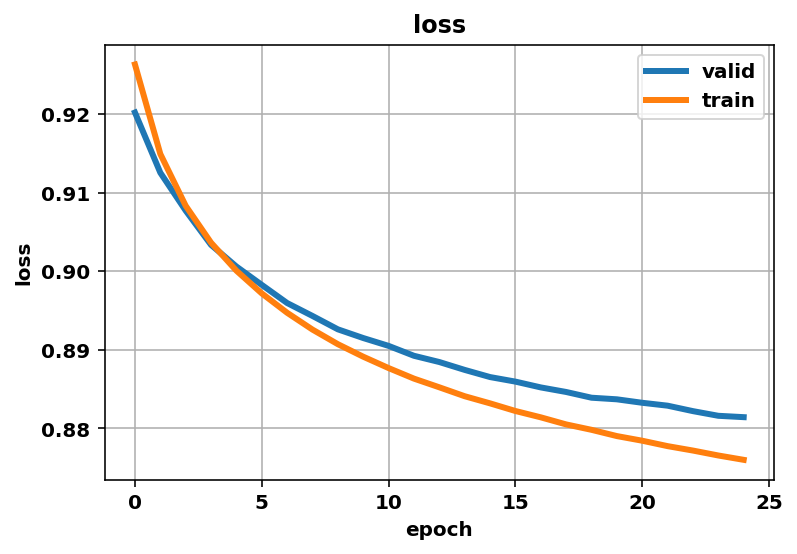

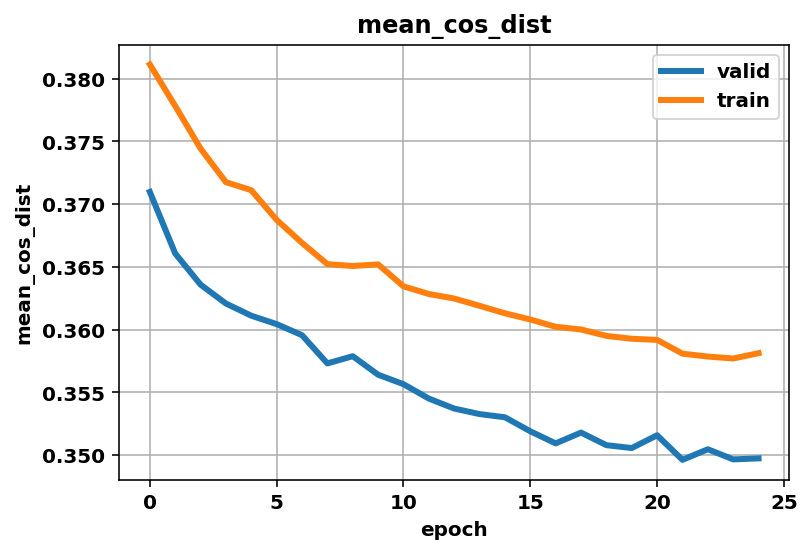

In [24]:
history.update(metrics.mean_cos_dist)
history.update(metrics.val_mean_cos_dist)
for metric_name in METRICS_NAMES:
    plot_loss(history, metric_name)

In [205]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(
        model,
        to_file="images/model/LTSTM_30_plot.png",
        show_shapes=True,
        show_layer_names=False,
    )

NameError: name 'model' is not defined

In [403]:
def save_model(model, model_name):
    model_json = model.to_json()
    with open("models/"+model_name+".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("models/"+model_name+".h5")
    print("Saved model to disk")
    
save_model(model, "LSTM_30_epoch")

Saved model to disk


In [404]:
print(X_train[0][0], ft.wv.most_similar(X_train[0][0].reshape(1,-1))[0], sep="\n")

[ 0.2831416   1.9003518  -0.5969981   0.04515171  0.88170296 -1.8052266
 -0.28070796 -0.7344635  -0.5129904   0.5274376  -0.50100714  0.35816643
 -0.50922704 -1.9544994   0.02911769  1.1419986   0.01741598  0.5366339
 -1.4860406   0.5877922  -0.6481257   1.7070045  -0.65793806  1.18562
  0.46790358 -0.45111388  0.16563676 -2.42333    -0.20980245  0.73004264
  0.1077087  -0.0410464  -1.8511068  -0.4033527   0.5019449   1.9654834
 -0.8074281  -0.7183717  -0.638709    1.6402546   1.4586475  -0.3450368
 -0.8329103  -0.53891575 -0.8557045   0.56288075 -0.14011712 -0.19686495
 -1.7863393   0.06247514  0.5551195  -1.4328742   1.5419097  -0.2912826
 -1.1314827   0.41545781 -0.6453534   0.49623677 -0.38735077 -1.5992879
  1.1138496  -1.2525398  -0.26182267 -0.30861476]
('Dbo7', 1.0000001192092896)


In [405]:
X_test[0][np.newaxis, :].shape, X_test[0:1].shape

((1, 3, 64), (1, 3, 64))

In [406]:
y_pred = model.predict(X_val)

In [410]:
X_train[0]

array([[ 0.2831416 ,  1.9003518 , -0.5969981 ,  0.04515171,  0.88170296,
        -1.8052266 , -0.28070796, -0.7344635 , -0.5129904 ,  0.5274376 ,
        -0.50100714,  0.35816643, -0.50922704, -1.9544994 ,  0.02911769,
         1.1419986 ,  0.01741598,  0.5366339 , -1.4860406 ,  0.5877922 ,
        -0.6481257 ,  1.7070045 , -0.65793806,  1.18562   ,  0.46790358,
        -0.45111388,  0.16563676, -2.42333   , -0.20980245,  0.73004264,
         0.1077087 , -0.0410464 , -1.8511068 , -0.4033527 ,  0.5019449 ,
         1.9654834 , -0.8074281 , -0.7183717 , -0.638709  ,  1.6402546 ,
         1.4586475 , -0.3450368 , -0.8329103 , -0.53891575, -0.8557045 ,
         0.56288075, -0.14011712, -0.19686495, -1.7863393 ,  0.06247514,
         0.5551195 , -1.4328742 ,  1.5419097 , -0.2912826 , -1.1314827 ,
         0.41545781, -0.6453534 ,  0.49623677, -0.38735077, -1.5992879 ,
         1.1138496 , -1.2525398 , -0.26182267, -0.30861476],
       [-0.12298293, -0.09537581,  0.11507685,  0.18755089, -0.

In [431]:
def print_example_predictions(model, X_test, y_test, embedding):
    for i in range(20):
        x_test_ex = X_test[i]
        y_pred = model.predict(x_test_ex[np.newaxis, :])
        #     print(embedding.wv.most_similar(y_test[i].reshape(1,-1))[0][0] in [d[0] for d in embedding.wv.most_similar(y_pred)][:10], end="\t")
        print(embedding.wv.most_similar(x_test_ex[0].reshape(1,-1))[0][0], end="\t")
        print(embedding.wv.most_similar(x_test_ex[1].reshape(1,-1))[0][0], end="\t")
        print(embedding.wv.most_similar(x_test_ex[2].reshape(1,-1))[0][0], end="\t")
        print("(", embedding.wv.most_similar(y_test[i].reshape(1,-1))[0][0], end=" )\t")
        print([d[0] for d in embedding.wv.most_similar(y_pred)][:5])

Dbo7	G^7	E7	( B-7 )	['Ebh', 'Ebh9', 'A7', 'Ebh7', 'A6']
B6	Gb6	Gb6	( B )	['Db-11', 'Db2', 'A6', 'Db-#5', 'Dbh9']
D7	Db7	Gb-	( Eb7sus )	['Db-b6', 'Ebh', 'A6', 'Ebh7', 'A^7']
Bb7	Eb	Eb7	( Db7 )	['A6', 'E+', 'Co', 'Gb+', 'A']
Ab^7	Db^7	Ab^7	( B7 )	['Ebh', 'A6', 'Db-', 'Ebh7', 'Co7']
Gb^7	Bbh7	Eb7b9	( F7 )	['Ebh', 'Db-b6', 'Ebh7', 'Gb-b6', 'Db-']
A	Db7	Db7	( C6 )	['Ebh9', 'Ebh', 'Db-6', 'Db-', 'A^7']
Eb7	C7	F-7	( D7 )	['A6', 'Ebh', 'Db-', 'Gb+', 'A']
A7	Eh	A7	( Bb^7 )	['Ebo', 'Ebo7', 'A6', 'Ebh', 'A+']
Db-7	Gb7	B^7	( A7 )	['Ebh', 'Ebh9', 'Ebh7', 'A6', 'Eb-7']
Bb-7	Ab-7	Bb-7	( D7 )	['Co7', 'Ebh', 'Db-', 'A^7', 'Db-b6']
C7	F-7	Bb7	( E-7 )	['A6', 'Ebh', 'B-b6', 'Db-', 'Db-b6']
Eb	Bb6	Eh7	( G7 )	['Ebh', 'A6', 'Db-', 'Ebh7', 'B-7']
G^7	E7	Gb-7	( A^7 )	['A+', 'Ebh', 'A6', 'A', 'Gb-6']
C7	B^7	D7	( G )	['Ebh', 'A6', 'Ebh9', 'Ebh7', 'Do7']
E7	A	A	( D-7 )	['Ebh9', 'Ebh', 'Ebh7', 'Db-6', 'Eb7b9#9']
Eb7	Ab7	Db	( C-7 )	['A^', 'Db-', 'A6', 'A', 'Db-b6']
D7#5	D7#5	G-11	( D7b9 )	['A^7', 'Co7', 'C^7', 'Ebh

In [478]:
def generate_song(init_seq, length=16):
    sample = ft.wv[init_seq]
    song = sample
    for i in range(length-sample.shape[0]):
        next_chord = model.predict(sample[np.newaxis, :])
        sample = np.vstack([sample[1:],next_chord])
        song = np.vstack([song, next_chord])
    song = [ft.wv.most_similar(chord.reshape(1,-1))[0][0] for chord in song]
    print("Sample Song")
    for i, c in enumerate(song):
        print(c, end="\t|\t")
        if i%4 == 3:
            print("")
            
generate_song(['A^7','B-7','E7'], length=16)

Sample Song
A^7	|	B-7	|	E7	|	Ebh	|	
Ebh	|	Ebh	|	E7	|	Db-	|	
Db-	|	A^7	|	A^7	|	Ebh7	|	
Ebh	|	Ebh	|	Ebh	|	Ebh	|	


In [468]:
X_train[200][1:].shape

(2, 64)

In [469]:
model.predict(X_train[200][1:])

ValueError: Error when checking input: expected lstm_26_input to have 3 dimensions, but got array with shape (2, 64)